In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [3]:
n = 1661 #novel number
t = 'Sherlock'#novel name
s = 1 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [4]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [5]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [6]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [7]:
df_novel.head()

,0
0,A Scandal in Bohemia II.
1,The Red-headed League III.
2,A Case of Identity IV.
3,The Boscombe Valley Mystery V. The Five Ora...
4,The Man with the Twisted Lip VII.


Create the wrd_length and total_char columns.

In [8]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [9]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [10]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [11]:
df_novel.head()

,0,wrd_length,total_char
0,A Scandal in Bohemia II.,"[1, 7, 2, 7, 2]",19
1,The Red-headed League III.,"[3, 10, 6, 3]",22
2,A Case of Identity IV.,"[1, 4, 2, 8, 2]",17
3,The Boscombe Valley Mystery V. The Five Ora...,"[3, 8, 6, 7, 1, 3, 4, 6, 4, 2]",44
4,The Man with the Twisted Lip VII.,"[3, 3, 4, 3, 7, 3, 3]",26


Create syllable count column

In [12]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [13]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [14]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [15]:
df_novel['syl_count'] = syl_count_arr

In [16]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,A Scandal in Bohemia II.,"[1, 7, 2, 7, 2]",19,"[1, 2, 1, 4, 1]"
1,The Red-headed League III.,"[3, 10, 6, 3]",22,"[1, 3, 2, 1]"
2,A Case of Identity IV.,"[1, 4, 2, 8, 2]",17,"[1, 1, 1, 4, 1]"
3,The Boscombe Valley Mystery V. The Five Ora...,"[3, 8, 6, 7, 1, 3, 4, 6, 4, 2]",44,"[1, 2, 2, 3, 0, 1, 1, 2, 1, 1]"
4,The Man with the Twisted Lip VII.,"[3, 3, 4, 3, 7, 3, 3]",26,"[1, 1, 1, 1, 1, 1, 1]"


In [17]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [18]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [19]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [20]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [21]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Write all columns to csv file

In [22]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [23]:
#test
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [24]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,A Scandal in Bohemia II.,"[1, 7, 2, 7, 2]",19,[1 2 1 4 1],9,0.0
1,The Red-headed League III.,"[3, 10, 6, 3]",22,[1 3 2 1],7,0.0
2,A Case of Identity IV.,"[1, 4, 2, 8, 2]",17,[1 1 1 4 1],8,0.0
3,The Boscombe Valley Mystery V. The Five Ora...,"[3, 8, 6, 7, 1, 3, 4, 6, 4, 2]",44,[1 2 2 3 0 1 1 2 1 1],14,0.0
4,The Man with the Twisted Lip VII.,"[3, 3, 4, 3, 7, 3, 3]",26,[1 1 1 1 1 1 1],7,-0.5


Create cluster dataframe - remove columns that can't be used

In [25]:
df_cluster = df_novel.drop('wrd_length', 1)

In [26]:
df_cluster = df_cluster.drop('syl_count', 1)

In [27]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,A Scandal in Bohemia II.,19,9,0.0
1,The Red-headed League III.,22,7,0.0
2,A Case of Identity IV.,17,8,0.0
3,The Boscombe Valley Mystery V. The Five Ora...,44,14,0.0
4,The Man with the Twisted Lip VII.,26,7,-0.5


Create 20 clusters on scaled data

In [28]:
X = df_cluster.drop(0, axis=1)

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [31]:
df_cluster['cluster'] = km.labels_

In [32]:
df_cluster.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,37.049308,11.836505,0.003146
1,107.688259,34.834008,0.255680
2,137.847880,43.748130,-0.051447
3,67.767742,22.032258,0.265237
4,100.304703,31.944785,0.003402
5,37.875000,12.538462,-0.533626
6,65.722798,20.863990,0.003095
7,31.484536,10.195876,0.851942
8,88.059259,28.755556,0.610046


In [33]:
centers = df_cluster.groupby('cluster').mean()

Create Scatter plot 

In [34]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

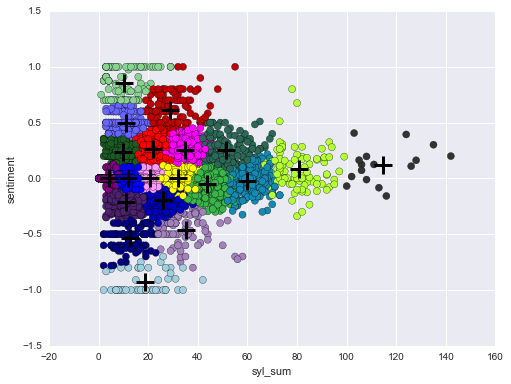

In [35]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster.syl_sum, df_cluster.sentiment, c=colors[df_cluster.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Create 3 clusters

In [36]:
df_cluster_3 = df_cluster

In [37]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,A Scandal in Bohemia II.,19,9,0.0,11
1,The Red-headed League III.,22,7,0.0,11
2,A Case of Identity IV.,17,8,0.0,11
3,The Boscombe Valley Mystery V. The Five Ora...,44,14,0.0,0
4,The Man with the Twisted Lip VII.,26,7,-0.5,5


In [38]:
X = df_cluster_3.drop(0, axis=1)

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [41]:
df_cluster_3['cluster'] = km.labels_

In [42]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,72.637173,23.200000,0.040332
1,22.716889,7.223977,0.036990
2,185.304991,59.937153,0.044247


Create 3 Clusters with no syl_sum

In [43]:
df_cluster_no_syl = df_cluster

In [44]:
df_cluster_no_syl = df_cluster.drop('syl_sum', 1)

In [45]:
X = df_cluster_no_syl.drop(0, axis=1)

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [48]:
df_cluster_no_syl['cluster'] = km.labels_

In [49]:
df_cluster_no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,72.637173,0.040332
1,22.716889,0.036990
2,185.304991,0.044247


Create 5 Clusters

In [50]:
df_cluster_5 = df_cluster

In [51]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment,cluster
0,A Scandal in Bohemia II.,19,9,0.0,1
1,The Red-headed League III.,22,7,0.0,1
2,A Case of Identity IV.,17,8,0.0,1
3,The Boscombe Valley Mystery V. The Five Ora...,44,14,0.0,0
4,The Man with the Twisted Lip VII.,26,7,-0.5,1


In [52]:
X = df_cluster_5.drop(0, axis=1)

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [55]:
df_cluster_5['cluster'] = km.labels_

In [56]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,20.681927,6.527897,-0.041743
1,108.202684,34.511299,0.023312
2,185.453704,59.985185,0.046180
3,49.703282,15.856427,-0.008931
4,48.084048,15.691252,0.546339


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [57]:
df_novel['total_char'].sum()

433812

In [58]:
ratio = (df_novel['total_char'].sum()/20) - 50

In [59]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - 100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [60]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:386]
df_novel['total_char'][386:784]
df_novel['total_char'][784:1119]
df_novel['total_char'][1119:1419]
df_novel['total_char'][1419:1723]
df_novel['total_char'][1723:2034]
df_novel['total_char'][2034:2397]
df_novel['total_char'][2397:2756]
df_novel['total_char'][2756:3032]
df_novel['total_char'][3032:3420]
df_novel['total_char'][3420:3799]
df_novel['total_char'][3799:4116]
df_novel['total_char'][4116:4496]
df_novel['total_char'][4496:4793]
df_novel['total_char'][4793:5111]
df_novel['total_char'][5111:5501]
df_novel['total_char'][5501:5796]
df_novel['total_char'][5796:6163]
df_novel['total_char'][6163:6485]
df_novel['total_char'][6485:6825]


In [61]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
386
0.0509266125354
386
784
0.0686820385784
784
1119
0.0639018724504
1119
1419
0.0550935487352
1419
1723
0.0424481339093
1723
2034
0.0106209174891
2034
2397
0.0250724723955
2397
2756
0.0461287841685
2756
3032
0.0314943648005
3032
3420
0.0279216433147
3420
3799
0.0532504500166
3799
4116
0.0184840225495
4116
4496
0.0385306248576
4496
4793
0.0456015395472
4793
5111
0.0140635285545
5111
5501
0.0355431460735
5501
5796
0.0365644654254
5796
6163
0.00769325685164
6163
6485
0.0766707097107
6485
6825
0.0370605589944


In [62]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.05092661  0.06868204  0.06390187  0.05509355  0.04244813  0.01062092
  0.02507247  0.04612878  0.03149436  0.02792164  0.05325045  0.01848402
  0.03853062  0.04560154  0.01406353  0.03554315  0.03656447  0.00769326
  0.07667071  0.03706056]


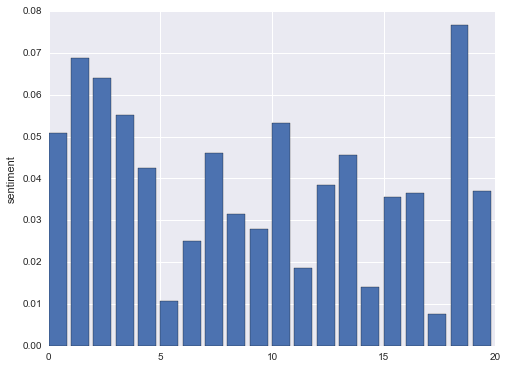

In [63]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [64]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
6825,And thus was solved the mystery of the siniste...,"[3, 4, 3, 6, 3, 7, 2, 3, 8, 5, 4, 3, 6, 7, 2, ...",80,"[1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 2, 1, 1, ...",24,-0.500000
6826,"Mr. Rucastle survived, but was always a broken...","[2, 8, 8, 3, 3, 6, 1, 6, 3, 4, 5, 6, 7, 3, 4, ...",85,"[0, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1, 1, ...",26,-0.150000
6827,"They still live with their old servants, who p...","[4, 5, 4, 4, 5, 3, 8, 3, 8, 4, 2, 4, 2, 8, 2, ...",110,"[1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 2, 0, ...",31,-0.062727
6828,"Mr. Fowler and Miss Rucastle were married, by ...","[2, 6, 3, 4, 8, 4, 7, 2, 7, 7, 2, 11, 3, 3, 5,...",150,"[0, 2, 1, 1, 2, 1, 2, 1, 3, 2, 1, 3, 1, 1, 2, ...",48,0.303571
6829,"As to Miss Violet Hunter, my friend Holmes, ra...","[2, 2, 4, 6, 6, 2, 6, 6, 6, 2, 2, 14, 10, 2, 7...",233,"[1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 4, 3, 1, 2, ...",74,-0.040000


In [65]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) -100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [66]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:2299]
df_novel['total_char'][2299:4582]
df_novel['total_char'][4582:6829]


KeyboardInterrupt: 

In [67]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
2299
0.0454520321242
2299
4582
0.0368768570214
4582
6829
0.0359097353521


In [68]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.04545203  0.03687686  0.03590974]


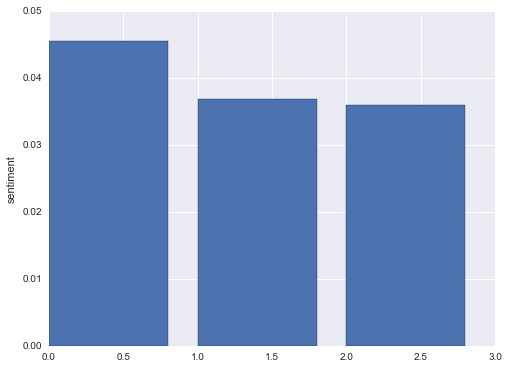

In [69]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers